# Обучение агента Humanoid с помощью алгоритма PPO продолжительностью 3 млн. шагов

Видео сохранено: ./ppo_humanoid_experiment_1/videos/episode_0.mp4


Видео сохранено: ./ppo_humanoid_experiment_2/videos/episode_0.mp4


Видео сохранено: ./ppo_humanoid_experiment_3/videos/episode_0.mp4


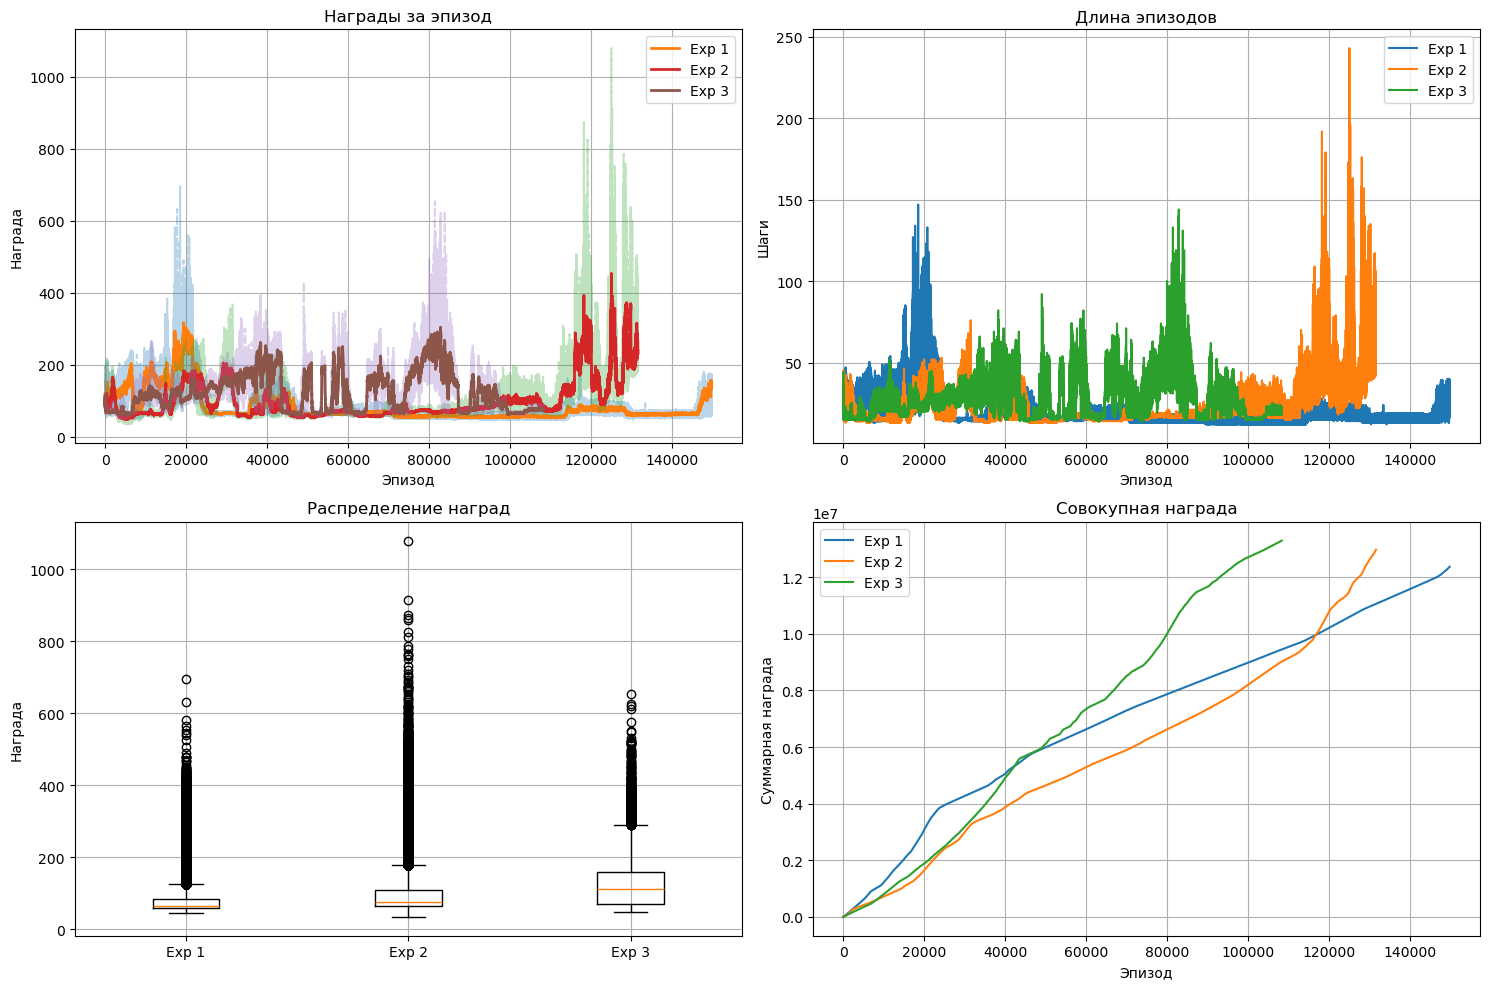

In [1]:
import os
import gymnasium as gym
import torch
import pandas as pd
import matplotlib.pyplot as plt
import imageio
from pyvirtualdisplay import Display
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
import warnings
import uuid
from IPython.display import HTML
import base64

# Настройка виртуального дисплея
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

# Конфигурация окружения
os.environ['MUJOCO_GL'] = 'osmesa'
os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# Функция для отображения видео в Jupyter Notebook
def show_video(video_path):
    if len(video_path) > 0:
        video = open(video_path, "rb").read()
        video_encoded = base64.b64encode(video).decode("ascii")
        return HTML(f'<video width="480" height="480" controls><source src="data:video/mp4;base64,{video_encoded}" type="video/mp4"></video>')
    else:
        return "Видео не найдено"


def create_env():
    return gym.make(
        "Humanoid-v5",
        render_mode="rgb_array",
        disable_env_checker=True
    )


def save_video(frames, exp_id, episode):
    video_dir = f"./ppo_humanoid_experiment_{exp_id}/videos"
    os.makedirs(video_dir, exist_ok=True)
    filename = f"{video_dir}/episode_{episode}.mp4"
    
    with imageio.get_writer(filename, fps=30) as writer:
        for frame in frames:
            writer.append_data(frame)
    return filename


def run_experiment(exp_id, params, total_timesteps=100000):
    log_dir = f"./ppo_humanoid_experiment_{exp_id}"
    os.makedirs(log_dir, exist_ok=True)

    # Создание и обертки среды
    env = Monitor(create_env(), os.path.join(log_dir, "monitor.csv"))

    # Конфигурация модели
    base_params = {
        "policy": "MlpPolicy",
        "env": env,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
        "verbose": 0,
        "tensorboard_log": log_dir,
        "policy_kwargs": {
            "activation_fn": torch.nn.ReLU,
            "net_arch": [dict(pi=[256, 256], vf=[256, 256])]
        },
        "batch_size": 256,
        "target_kl": 0.1,
        "clip_range": 0.3
    }

    model = PPO(**{**base_params, **params})
    
    try:
        # Обучение модели
        model.learn(total_timesteps=total_timesteps)
        
        # Запись демонстрационного видео
        frames = []
        eval_env = create_env()
        obs, _ = eval_env.reset()
        
        for _ in range(1000):  # Максимальная длина видео
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, _ = eval_env.step(action)
            frames.append(eval_env.render())
            if terminated or truncated:
                break
        
        video_path = save_video(frames, exp_id, 0)
        print(f"Видео сохранено: {video_path}")
        
        # Отобразим видео для Breakout
        display(show_video(video_path))
    
        
    finally:
        model.save(os.path.join(log_dir, f"model_{exp_id}.zip"))
        env.close()
        eval_env.close()

experiment_params = [
    {"learning_rate": 3e-4, "n_steps": 2048, "ent_coef": 0.0,   "gamma": 0.99},
    {"learning_rate": 1e-3, "n_steps": 2048, "ent_coef": 0.01,  "gamma": 0.95},
    {"learning_rate": 5e-4, "n_steps": 1024, "ent_coef": 0.001, "gamma": 0.98}
]

# Запуск экспериментов
total_timesteps = 3000000
for idx, params in enumerate(experiment_params, 1):
    run_experiment(exp_id=idx, params=params, total_timesteps=total_timesteps)

# Построение расширенных графиков
plt.figure(figsize=(15, 10))

# Создаем 2x2 сетку графиков
ax1 = plt.subplot(2, 2, 1)
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 3)
ax4 = plt.subplot(2, 2, 4)

# Словарь для сбора данных по экспериментам
all_rewards = []

for idx in range(1, len(experiment_params) + 1):
    log_dir = f"./ppo_humanoid_experiment_{idx}"
    monitor_file = os.path.join(log_dir, "monitor.csv")
    
    if os.path.exists(monitor_file):
        df = pd.read_csv(monitor_file, skiprows=1)
        df['smoothed_r'] = df['r'].rolling(window=20, min_periods=1).mean()  # Скользящее среднее
        
        # График 1: Исходные и сглаженные награды
        ax1.plot(df.index, df['r'], alpha=0.3, linestyle='--')
        ax1.plot(df.index, df['smoothed_r'], linewidth=2, label=f"Exp {idx}")
        
        # График 2: Длина эпизодов
        ax2.plot(df.index, df['l'], label=f"Exp {idx}")
        
        # График 3: Гистограмма распределения наград
        all_rewards.append(df['r'])
        
        # График 4: Совокупная награда
        df['cumulative_r'] = df['r'].cumsum()
        ax4.plot(df.index, df['cumulative_r'], label=f"Exp {idx}")

# Настройка графиков
ax1.set_title("Награды за эпизод")
ax1.set_xlabel("Эпизод")
ax1.set_ylabel("Награда")
ax1.legend()
ax1.grid(True)

ax2.set_title("Длина эпизодов")
ax2.set_xlabel("Эпизод")
ax2.set_ylabel("Шаги")
ax2.legend()
ax2.grid(True)

ax3.set_title("Распределение наград")
ax3.boxplot(all_rewards, labels=[f"Exp {i+1}" for i in range(len(all_rewards))])
ax3.set_ylabel("Награда")
ax3.grid(True)

ax4.set_title("Совокупная награда")
ax4.set_xlabel("Эпизод")
ax4.set_ylabel("Суммарная награда")
ax4.legend()
ax4.grid(True)

plt.tight_layout()
plt.show()


# Остановка виртуального дисплея
virtual_display.stop()

## Выводы
Было проведено 3 эксперимента с различными гиперпараметрами. Обучение длилось в течение 3 млн шагов.

- **Эксперимент 1:** Медленный, но стабильный рост. Малое ent_coef может ограничивать исследование.
- **Эксперимент 2:** Быстрый старт благодаря высокому learning_rate, но большая волатильность из-за ent_coef=0.01.
- **Эксперимент 3:** Баланс между стабильностью и скоростью обучения. Лучший результат благодаря компромиссным параметрам.